# Survival Analysis Tutorial Part 2: Sessionization

This is the [World of Warcraft avatar dataset](https://www.kaggle.com/datasets/mylesoneill/warcraft-avatar-history), hosted on Kaggle.

It contains logs from a World of Warcraft server from 2008. Every ten minutes the system would log every player from the Horde faction if they were playing the game.

Furthermore, a user that has previously churned and later resubscribed, is treated as a new user with some covariate information describing the previous session history.

**This notebook perform sessionization: we create survival analysis features and labels from raw logs.**

For more context about sessionization, please check:
- [Olivier Grisel's presentation about sessionization](https://docs.google.com/presentation/d/1pAFmAFiyTA0_-ZjWG1rImAX8lYJt_UnGgqXD-4H6Aqw/edit#slide=id.g216ab5b12fe_0_65)
- [Polars library World of Warcraft sessionization tutorial](https://www.pola.rs/posts/the-expressions-api-in-polars-is-amazing/)

In [1]:
%pip install setuptools fastparquet lifelines "nbformat>=4.2.0" seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")

event_log = pd.read_parquet("data/wowah_data_raw_650k.parquet")
event_log

,char,level,race,charclass,zone,guild,timestamp
0,2288,60,Orc,Hunter,Hellfire Peninsula,-1,2008-01-01 00:02:09
1,49944,70,Orc,Warrior,Terokkar Forest,167,2008-01-01 00:02:19
2,4002,70,Orc,Hunter,The Mechanar,5,2008-01-01 00:02:24
3,64297,48,Tauren,Warrior,Tanaris,-1,2008-01-01 00:02:44
4,65181,26,Tauren,Shaman,Ashenvale,35,2008-01-01 00:02:44
...,...,...,...,...,...,...,...
627398,65852,80,Blood Elf,Hunter,Naxxramas,101,2008-12-31 23:49:48
627399,55037,80,Blood Elf,Priest,Dalaran,204,2008-12-31 23:49:58
627400,34396,80,Blood Elf,Priest,Dalaran,104,2008-12-31 23:49:58
627401,65296,77,Blood Elf,Priest,Dragonblight,62,2008-12-31 23:49:58


Let's display the time range of our dataset.

In [3]:
event_log["timestamp"].min(), event_log["timestamp"].max()

(Timestamp('2008-01-01 00:02:09'), Timestamp('2008-12-31 23:50:08'))

We then print the top 5 most frequent users.

In [4]:
event_log["char"].value_counts().head()

char
182      42801
65296    10614
65469     9274
29395     9154
31647     8018
Name: count, dtype: int64

The `session_threshold` is the main hyper-parameter of sessionization, as it controls the maximum period of time without activity to consider a user to have churned.

In [5]:
def sessionize(df, entity_col, date_col, session_threshold):
    """Create session indices.
    """
    df = df.sort_values([entity_col, date_col])
    df["lag"] = df.groupby(entity_col)[date_col].shift()
    df["is_new_session"] = (df[date_col] - df["lag"]) > session_threshold
    df["session_id"] = df.groupby(entity_col)["is_new_session"].cumsum()
    return df

In [6]:
session_threshold = "90 days"

sessions = sessionize(
    event_log,
    entity_col="char",
    date_col="timestamp",
    session_threshold=session_threshold,
)
print(sessions.shape)
sessions.head()

(627403, 10)


,char,level,race,charclass,zone,guild,timestamp,lag,is_new_session,session_id
11,91,70,Tauren,Druid,Tanaris,103,2008-01-01 00:03:15,NaT,False,0
59,91,70,Tauren,Druid,Tanaris,103,2008-01-01 00:13:03,2008-01-01 00:03:15,False,0
105,91,70,Tauren,Druid,Shattrath City,103,2008-01-01 00:23:28,2008-01-01 00:13:03,False,0
156,91,70,Tauren,Druid,Shattrath City,103,2008-01-01 00:33:16,2008-01-01 00:23:28,False,0
4918,91,70,Tauren,Druid,Shattrath City,103,2008-01-01 23:13:13,2008-01-01 00:33:16,False,0


In [7]:
def extract_session(df, entity_col, date_col, metadata_cols):
    """Group event log into sessions.
    """
    mc_agg = {col: (col, "first") for col in metadata_cols}
    date_agg = dict(session_start=(date_col, "min"), session_end=(date_col, "max"))
    sessions = (
        df.groupby([entity_col, "session_id"])
        .agg(**mc_agg, **date_agg)
        .reset_index()
    )
    sessions["duration"] = (sessions["session_end"] - sessions["session_start"]).dt.days
    return sessions

In [8]:
metadata_cols = ["level", "race", "charclass", "zone", "guild"]

session_extracted = extract_session(
    sessions,
    entity_col="char",
    date_col="timestamp",
    metadata_cols=metadata_cols,
)
print(session_extracted.shape)
session_extracted.head()

(515, 10)


,char,session_id,level,race,charclass,zone,guild,session_start,session_end,duration
0,91,0,70,Tauren,Druid,Tanaris,103,2008-01-01 00:03:15,2008-12-27 22:48:08,361
1,118,0,70,Tauren,Druid,Nagrand,5,2008-01-01 21:13:23,2008-04-08 21:31:22,98
2,132,0,70,Tauren,Warrior,Terokkar Forest,204,2008-01-02 23:53:06,2008-12-31 00:05:51,363
3,155,0,70,Tauren,Warrior,Blade's Edge Mountains,103,2008-01-01 00:53:19,2008-11-14 22:16:59,318
4,166,0,70,Tauren,Shaman,Zangarmarsh,5,2008-01-01 20:43:06,2008-09-30 13:05:45,272


In [9]:
def censor(df, entity_col, censoring_date, session_threshold, observation_days=None):
    """Define censoring with a right-censoring date and a between-session threshold.
    """
    
    df = df.loc[df["session_start"] < censoring_date]
    
    if observation_days:
        start_date = censoring_date - pd.Timedelta(days=observation_days)
        df = df.loc[df["session_start_date"] > start_date]
    
    # Last session churn
    last_session_id = (
        df.groupby(entity_col)
                .agg(last_session_id=("session_id", "last"))
                .reset_index()
    )
    df = df.merge(last_session_id, on=entity_col, how="left")
    
    is_survival = (
        (df["last_session_id"] == df["session_id"])
        & ((censoring_date - df["session_end"]) < session_threshold)
    )

    # Assemble both churn type
    df["event"] = ~is_survival
    
    return df

In [10]:
last_date_observed = session_extracted["session_start"].max()
observation_days = None

censoring = censor(
    session_extracted,
    entity_col="char",
    censoring_date=last_date_observed,
    session_threshold=session_threshold,
    observation_days=observation_days,
)
print(censoring.shape)
censoring.head()

(514, 12)


,char,session_id,level,race,charclass,zone,guild,session_start,session_end,duration,last_session_id,event
0,91,0,70,Tauren,Druid,Tanaris,103,2008-01-01 00:03:15,2008-12-27 22:48:08,361,0,False
1,118,0,70,Tauren,Druid,Nagrand,5,2008-01-01 21:13:23,2008-04-08 21:31:22,98,0,True
2,132,0,70,Tauren,Warrior,Terokkar Forest,204,2008-01-02 23:53:06,2008-12-31 00:05:51,363,0,False
3,155,0,70,Tauren,Warrior,Blade's Edge Mountains,103,2008-01-01 00:53:19,2008-11-14 22:16:59,318,0,False
4,166,0,70,Tauren,Shaman,Zangarmarsh,5,2008-01-01 20:43:06,2008-09-30 13:05:45,272,0,False


In [11]:
def contextualize_churn(df, entity_col):
    """Augment the dataset with context info from previous churned session.
    """
    
    # Get days since last churn
    df["previous_session_end"] = df.groupby(entity_col)["session_end"].shift()
    df["days_since_last_churn"] = (
        df["session_start"] - df["previous_session_end"]
    ).dt.days.fillna(0)
    
    # Get days since first start
    df = df.merge(
        df.groupby("char").agg(first_start=("session_start", "first")),
        on="char",
    )
    df["days_since_first_start"] = (df["session_start"] - df["first_start"]).dt.days
    
    # The number of churn is directly provided by session_id
    df = df.rename({"session_id": "number_of_previous_churn"}, axis=1)
    
    return df

In [12]:
contextualized = contextualize_churn(
    censoring,
    entity_col="char",
)
print(contextualized.shape)
contextualized.head()

(514, 16)


,char,number_of_previous_churn,level,race,charclass,zone,guild,session_start,session_end,duration,last_session_id,event,previous_session_end,days_since_last_churn,first_start,days_since_first_start
0,91,0,70,Tauren,Druid,Tanaris,103,2008-01-01 00:03:15,2008-12-27 22:48:08,361,0,False,NaT,0.0,2008-01-01 00:03:15,0
1,118,0,70,Tauren,Druid,Nagrand,5,2008-01-01 21:13:23,2008-04-08 21:31:22,98,0,True,NaT,0.0,2008-01-01 21:13:23,0
2,132,0,70,Tauren,Warrior,Terokkar Forest,204,2008-01-02 23:53:06,2008-12-31 00:05:51,363,0,False,NaT,0.0,2008-01-02 23:53:06,0
3,155,0,70,Tauren,Warrior,Blade's Edge Mountains,103,2008-01-01 00:53:19,2008-11-14 22:16:59,318,0,False,NaT,0.0,2008-01-01 00:53:19,0
4,166,0,70,Tauren,Shaman,Zangarmarsh,5,2008-01-01 20:43:06,2008-09-30 13:05:45,272,0,False,NaT,0.0,2008-01-01 20:43:06,0


## All together!

We chain all previous functions into a single one using `.pipe` from pandas.

In [13]:
def get_X_y(
    event_log,
    date_last_observed,
    session_threshold,
    observation_days=None,
):
    metadata_cols = ["level", "race", "charclass", "zone", "guild"]

    censored = (
        event_log.pipe(
            sessionize,
            entity_col="char",
            date_col="timestamp",
            session_threshold=session_threshold,
        )
        .pipe(
            extract_session,
            entity_col="char",
            date_col="timestamp",
            metadata_cols=metadata_cols,
        )
        .pipe(
            censor,
            entity_col="char",
            censoring_date=date_last_observed,
            session_threshold=session_threshold,
            observation_days=None,
        )
        .pipe(
            contextualize_churn,
            entity_col="char",
        )
    )
        
    churn_cols = [
        "days_since_last_churn",
        "days_since_first_start",
        "number_of_previous_churn",
    ]
    feature_cols = metadata_cols + churn_cols
    X = censored[feature_cols]
    
    target_cols = ["event", "duration"]
    y = censored[target_cols]
        
    return X, y

In [14]:
date_last_observed = event_log["timestamp"].max()
session_threshold = "90 days"

X, y = get_X_y(
    event_log,
    date_last_observed=date_last_observed,
    session_threshold=session_threshold,
    observation_days=None,
)

# We only keep users that played during 2 different days at least.
# For example, a user that only played a single afternoon will be removed,
# because its duration would have been 0 day (less than 1 day).
mask = (y["duration"] > 0)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

print(X.shape, y.shape)
X.head()

(455, 8) (455, 2)


,level,race,charclass,zone,guild,days_since_last_churn,days_since_first_start,number_of_previous_churn
0,70,Tauren,Druid,Tanaris,103,0.0,0,0
1,70,Tauren,Druid,Nagrand,5,0.0,0,0
2,70,Tauren,Warrior,Terokkar Forest,204,0.0,0,0
3,70,Tauren,Warrior,Blade's Edge Mountains,103,0.0,0,0
4,70,Tauren,Shaman,Zangarmarsh,5,0.0,0,0


In [15]:
y["event"].value_counts()

event
True     236
False    219
Name: count, dtype: int64

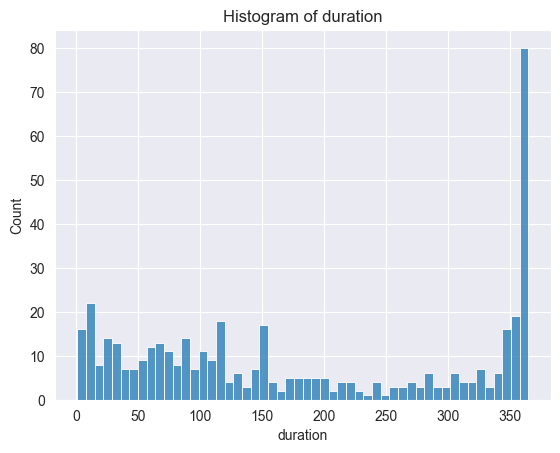

In [16]:
ax = sns.histplot(y["duration"], bins=52);
ax.set(title="Histogram of duration");

In [17]:
#slug = session_threshold.replace(" ", "")
#X.to_parquet(f"data/wowah_session_features_{slug}.parquet", index=False)
#y.to_parquet(f"data/wowah_session_events_{slug}.parquet", index=False)